In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import os
import shutil
import time

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



In [3]:
if 'images' in os.listdir():
    os.system('rm -rf images')
os.makedirs('images')

In [4]:
# Input Parameters
n_inputs = 2
n_outputs = 1
maxValue = 2
minValue = -2
smooth = 25
createGif = True

# Hyper Parameters
n_hidden1 = 8
alpha = 0.02
testSize = 1000
batchSize = 50
episodes = 3000

optimizers = [tf.train.GradientDescentOptimizer, 
              tf.train.AdamOptimizer, 
              tf.train.AdagradOptimizer, 
              tf.train.RMSPropOptimizer]
optimizer = optimizers[1]

activations = [tf.nn.sigmoid,
               tf.nn.elu,
               tf.nn.relu,
               tf.nn.leaky_relu,
               tf.nn.tanh]
activation = activations[4]

# TF Variables
X = tf.placeholder(tf.float32, shape=(None,n_inputs))
Y_ = tf.placeholder(tf.float32, shape=(None,1), name='YHat')

In [5]:
def ourFunction(a,b):
    return a + b

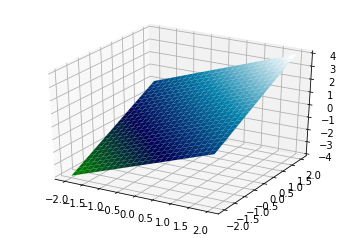

In [6]:
ax = plt.axes(projection='3d')
x = np.outer(np.linspace(minValue, maxValue, smooth), np.ones(smooth))
y = x.copy().T
z = ourFunction(x,y)
ax.plot_surface(x, y, z, cmap='ocean', rstride=1, cstride=1, linewidth=0)
plt.show()
plt.close()

In [7]:
# One Hidden Layer Neural Network with one output
with tf.name_scope('Layer1'):
    weights1 = tf.Variable(tf.truncated_normal([n_inputs,n_hidden1], 
                                               dtype=tf.float32,
                                               stddev=1),  
                                               name='weights1')
    biases1 = tf.Variable(tf.constant(0.0, shape=[n_hidden1], dtype=tf.float32), name='biases1')
    outputs1 = tf.matmul(X,weights1)
    outputs1 = tf.nn.bias_add(outputs1,biases1)
    outputs1 = activation(outputs1)
    
with tf.name_scope('Output'):
    weights2 = tf.Variable(tf.truncated_normal([n_hidden1,n_outputs], 
                                               dtype=tf.float32,
                                               stddev=1), 
                                               name='weights2')
    biases2= tf.Variable(tf.constant(0.0, shape=[n_outputs], dtype=tf.float32), name='biases2')
    outputs2 = tf.matmul(outputs1, weights2)
    output = tf.nn.bias_add(outputs2, biases2)
    
    
    

In [8]:
tf.trainable_variables()


[<tf.Variable 'Layer1/weights1:0' shape=(2, 8) dtype=float32_ref>,
 <tf.Variable 'Layer1/biases1:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'Output/weights2:0' shape=(8, 1) dtype=float32_ref>,
 <tf.Variable 'Output/biases2:0' shape=(1,) dtype=float32_ref>]

In [9]:
# Create Error measurement and Optimizer
error = tf.reduce_mean((output - Y_)**2)
training = optimizer(alpha).minimize(error)

In [10]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [11]:
# Check if Existing Tensorboard Log Exists
if os.path.isdir('/tmp/approx'):
    print('Deleting Old TB Directory')
    shutil.rmtree('/tmp/approx')
    os.system('rm -rf /tmp/approx')
    time.sleep(2)

Deleting Old TB Directory


In [12]:
# Setup TensorBoard Writer

writer = tf.summary.FileWriter('/tmp/approx')
tf.summary.scalar('Loss', error)
tf.summary.histogram('Weights_1', weights1)
tf.summary.histogram('Weights_2', weights2)
tf.summary.histogram('Biases_1', biases1)
tf.summary.histogram('Biases_2', biases2)
write_op = tf.summary.merge_all()
writer.add_graph(sess.graph)

In [13]:
# Build Test Set
test = np.random.uniform(minValue,maxValue, size=(5000,2))
test_y = ourFunction(test[:,0],test[:,1])
test_y = test_y.reshape(len(test_y),1)

In [14]:
tf_list = []
for i in x[:,0]:
    for ii in y[0,:]:
        tf_list.append([i,ii])
tf_list = np.array(tf_list)

In [15]:
for i in range(episodes):
    # Build Training Set
    
    if i < 500 and i % 2 == 0 and createGif:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(211,projection='3d')
        ax.plot_surface(x, y, z, cmap='ocean', rstride=1, cstride=1, linewidth=0)
        
        ax = fig.add_subplot(212,projection='3d')
        plotpoints = sess.run(output, feed_dict={X:tf_list})
        z2 = plotpoints.reshape(smooth,smooth)
        ax.plot_surface(x, y, z2, cmap='gnuplot', rstride=1, cstride=1, linewidth=0)
        fig.savefig('images/test'+str(i)+'.png')
        plt.close()
    
    # Create Random Training Data
    train = np.random.uniform(minValue-1, maxValue+1, size=(batchSize,n_inputs))
    train_y = ourFunction(train[:,0], train[:,1]) 
    train_y = train_y.reshape(len(train_y),1)
    # Run Forward Pass of Data & Update Parameters
    _ , errors = sess.run([training, error], feed_dict={X: train, Y_: train_y})
    
     
    if i % 100 == 0:
        # Write TF Summaries
        summary = sess.run(write_op, feed_dict={X: train, Y_: train_y})
        writer.add_summary(summary, i)
        writer.flush()
        
        # Print Error Results
        print('Total Training Error {}'.format(errors))
        outputs, errors = sess.run([output, error], feed_dict={X: test, Y_: test_y})
        print('Test Set Error {}'.format(errors))
        print('-----------------------------------')
        
    if i > 500 and i % 250 == 0 and createGif:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(211,projection='3d')
        ax.plot_surface(x, y, z, cmap='ocean', rstride=1, cstride=1, linewidth=0)
        
        ax = fig.add_subplot(212,projection='3d')
        plotpoints = sess.run(output, feed_dict={X:tf_list})
        z2 = plotpoints.reshape(smooth,smooth)
        ax.plot_surface(x, y, z2, cmap='gnuplot', rstride=1, cstride=1, linewidth=0)
        #test = plt.show()
        fig.savefig('images/test'+str(i)+'.png')
        plt.close()
        
    

Total Training Error 12.905498504638672
Test Set Error 6.151769638061523
-----------------------------------
Total Training Error 0.19760750234127045
Test Set Error 0.12233896553516388
-----------------------------------
Total Training Error 0.034057583659887314
Test Set Error 0.03463420271873474
-----------------------------------
Total Training Error 0.012220876291394234
Test Set Error 0.007013897877186537
-----------------------------------
Total Training Error 0.0037832295056432486
Test Set Error 0.006255406886339188
-----------------------------------
Total Training Error 0.007244648411870003
Test Set Error 0.0054235681891441345
-----------------------------------
Total Training Error 0.003603499149903655
Test Set Error 0.002790195168927312
-----------------------------------
Total Training Error 0.0065817805007100105
Test Set Error 0.0022669360041618347
-----------------------------------
Total Training Error 0.004792936611920595
Test Set Error 0.0011429126607254148
-------------

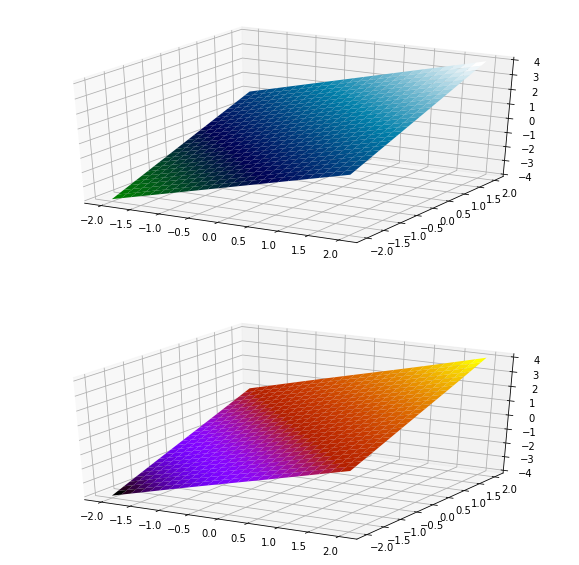

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211,projection='3d')

#plt.subplot(2, 1, 2)
ax.plot_surface(x, y, z, cmap='ocean', rstride=1, cstride=1, linewidth=0)

#plt.subplot(2, 1, 1)
ax = fig.add_subplot(212,projection='3d')
plotpoints = sess.run(output, feed_dict={X:tf_list})
z2 = plotpoints.reshape(smooth,smooth)
ax.plot_surface(x, y, z2, cmap='gnuplot', rstride=1, cstride=1, linewidth=0)
test = plt.show()
fig.savefig('final.png')

In [17]:
if createGif:
    os.chdir('images')
    os.system('convert -delay 10 -loop 0 `ls -v` image.gif')